In [1]:
# Import dependencies
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping    
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
#Data preprocessing
#Define the path of the dataset and get the labels for categories
data_path='./dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]
#Create the dict with labels and numeric values correspending
label_dict=dict(zip(categories,labels))
print('Dict to use:')
print(label_dict)
print(categories)

Dict to use:
{'asuna': 0, 'chizuru': 1, 'ichika': 2, 'itsuki': 3, 'kaede': 4, 'mai': 5, 'mami': 6, 'miku': 7, 'nino': 8, 'rei': 9, 'ruka': 10, 'serena': 11, 'sumi': 12, 'yotsuba': 13, 'zerotwo': 14}
['asuna', 'chizuru', 'ichika', 'itsuki', 'kaede', 'mai', 'mami', 'miku', 'nino', 'rei', 'ruka', 'serena', 'sumi', 'yotsuba', 'zerotwo']


In [3]:
#Define the fixed size
img_size=(150, 300)
data=[]
target=[]

In [4]:
#Runs every folder and add every img and label corresponding to folder
for category in tqdm(categories, desc="Processing images"):
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)
    
    for img_name in tqdm(img_names, desc=f"Processing images in {category}", leave=False):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Error loading image: {img_path}")
            continue

        try:
            resized = cv2.resize(img, (img_size[0], img_size[1]))
            data.append(resized)
            target.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

# Convert lists to arrays
# data=np.array(data)/255.0
data=np.reshape(data,(len(data),img_size[1], img_size[0],3))
target=np.array(target)
target=to_categorical(target)

Processing images: 100%|██████████| 15/15 [03:33<00:00, 14.23s/it]


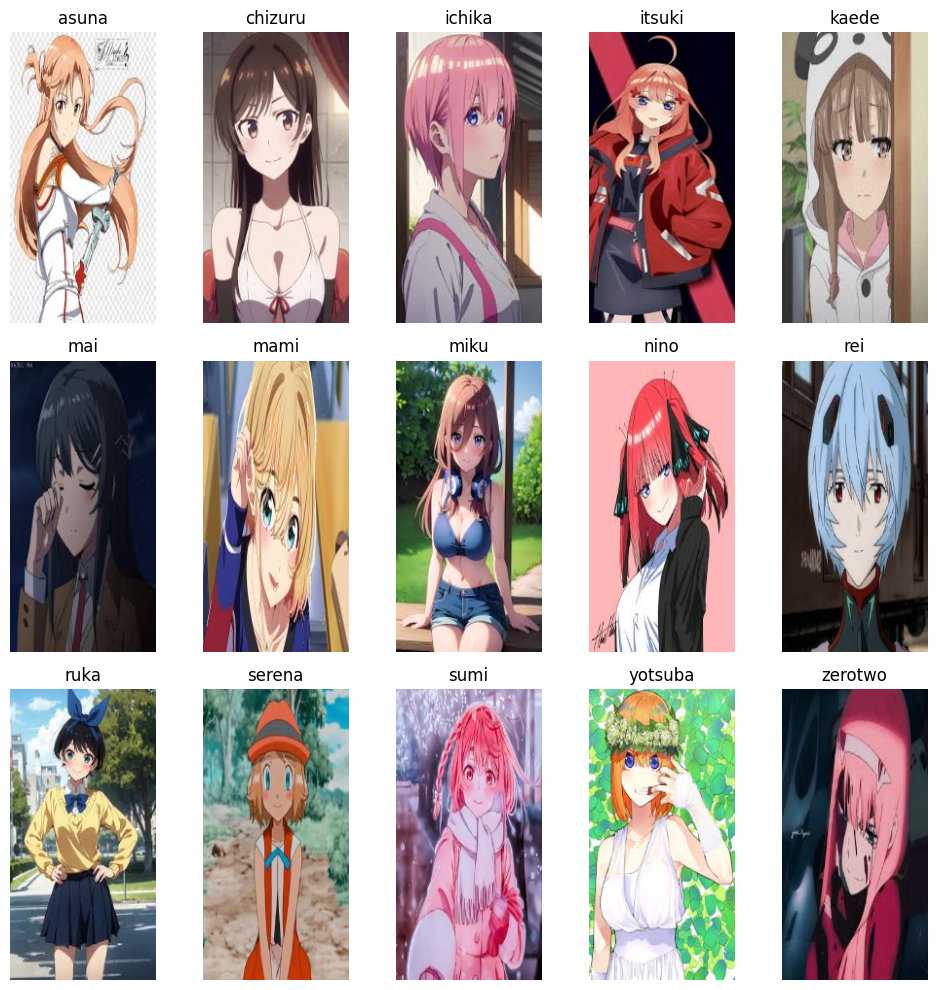

In [9]:
# Mostrar una imagen por cada clase con 5 imágenes por fila
index_to_label = {v: k for k, v in label_dict.items()}
unique_classes = list(label_dict.keys())
num_classes = len(unique_classes)

# Calcular las filas necesarias y establecer 5 columnas
num_cols = 5
num_rows = -(-num_classes // num_cols)  # Redondeo hacia arriba

plt.figure(figsize=(10, 10))  # Ajustar tamaño de la figura

for i, class_name in enumerate(unique_classes):
    # Filtrar índices correspondientes a la clase actual
    class_indices = [j for j, label in enumerate(target) if np.argmax(label) == label_dict[class_name]]

    # Seleccionar un índice aleatorio dentro de la clase
    if class_indices:
        random_index = np.random.choice(class_indices)
        img_to_show = data[random_index]
        img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)

        # Mostrar la imagen
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img_to_show)
        plt.title(f"{class_name}")
        plt.axis('off')
    else:
        print(f"No images found for class: {class_name}")

plt.tight_layout()
plt.show()


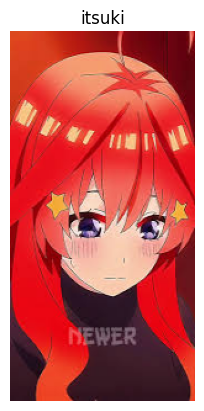

In [23]:
index = np.random.randint(0, len(data))
img_to_show = data[index]
img_to_show = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)

index_to_label = {v: k for k, v in label_dict.items()}
label_index = np.argmax(target[index])
label_name = index_to_label[label_index]
plt.imshow(img_to_show)
plt.title(f"{label_name}")
plt.axis('off')
plt.show()
#{'ichika': 0, 'itsuki': 1, 'miku': 2, 'nino': 3, 'yotsuba': 4}

In [24]:
# Split the dataset into training and validation sets
# stratofy is for save the proportion for each class
X_train, X_temp, y_train, y_temp = train_test_split(data, target, test_size=0.3, random_state=42, stratify=target)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42, stratify=y_temp)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (8400, 300, 150, 3)
Validation data shape: (2160, 300, 150, 3)
Test data shape: (1440, 300, 150, 3)
Training labels shape: (8400, 15)
Validation labels shape: (2160, 15)
Test labels shape: (1440, 15)


In [38]:
# Model training
# Load EfficientNetB0  preajusted with imagenet without last layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size[1], img_size[0], 3))

base_model.trainable = True
# Freeze all layers except the last few
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add more layers
model = models.Sequential([
    # layers from EfficientNetB0
    base_model,
    # reduce the data size keeping most important values
    layers.GlobalAveragePooling2D(),
    # delete random 20% of the conecctions
    layers.Dropout(0.2),
    # dense layer with 128 neurons
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    # output layer one for each class and softmax to get probability
    layers.Dense(15, activation='softmax')
])

# Optimizer adam and loss function for classification in base of accuaracy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early stoping --> if not improve later than 7 epochs restore best weights
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 10, 5, 1280)    │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,215,474 (16.08 MB)

 Trainable params: 1,516,863 (5.79 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [27]:
class TestPerformanceCallback(Callback):
    def __init__(self, test_data):
        super(TestPerformanceCallback, self).__init__()
        self.test_data = test_data
        self.test_loss = []
        self.test_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        # Evaluate every epoch
        loss, accuracy = self.model.evaluate(self.test_data[0], self.test_data[1], verbose=0)
        self.test_loss.append(loss)
        self.test_accuracy.append(accuracy)
        print(f"Epoch {epoch + 1} - Test loss: {loss:.4f} - Test accuracy: {accuracy:.4f}")

In [39]:
# fit the model and save the history
test_performance_callback = TestPerformanceCallback((X_test, y_test))
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping, test_performance_callback])

Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.6314 - loss: 1.2006Epoch 1 - Test loss: 0.2870 - Test accuracy: 0.9181
263/263 ━━━━━━━━━━━━━━━━━━━━ 232s 825ms/step - accuracy: 0.6319 - loss: 1.1987 - val_accuracy: 0.9167 - val_loss: 0.2658
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9338 - loss: 0.2267Epoch 2 - Test loss: 0.2186 - Test accuracy: 0.9347
263/263 ━━━━━━━━━━━━━━━━━━━━ 215s 818ms/step - accuracy: 0.9338 - loss: 0.2267 - val_accuracy: 0.9375 - val_loss: 0.2009
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9613 - loss: 0.1190Epoch 3 - Test loss: 0.2538 - Test accuracy: 0.9299
263/263 ━━━━━━━━━━━━━━━━━━━━ 222s 846ms/step - accuracy: 0.9613 - loss: 0.1191 - val_accuracy: 0.9306 - val_loss: 0.2442
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.9697 - loss: 0.0937Epoch 4 - Test loss: 0.2470 - Test accuracy: 0.9299
263/263 ━━━━━━━━━━━━━━━━━━━━ 217s 824ms/step - accuracy: 0.9696 - loss: 0.0937 - 

In [40]:
model.save('exportedModels/modelmany.h5')

In [41]:
model.evaluate(X_test, y_test, verbose=2)

45/45 - 21s - 477ms/step - accuracy: 0.9576 - loss: 0.2021


[0.20210565626621246, 0.9576388597488403]

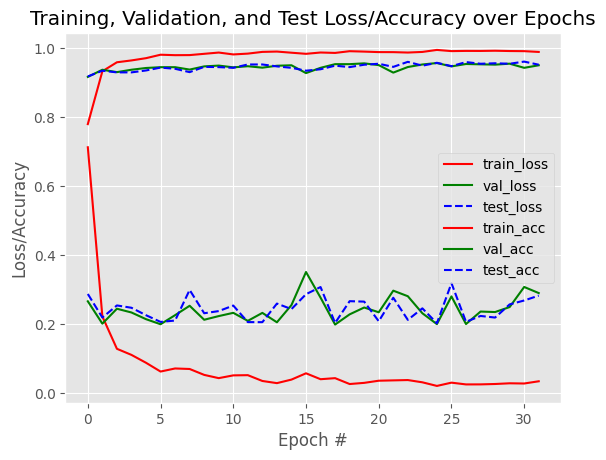

In [42]:
N = len(history.history["loss"])

plt.style.use("ggplot")
plt.figure()

# Loss
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss", color='red')
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss", color='green')
plt.plot(np.arange(0, N), test_performance_callback.test_loss, '--', label="test_loss", color='blue')

# Accuaracy
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc", color='red')
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc", color='green')
plt.plot(np.arange(0, N), test_performance_callback.test_accuracy, '--', label="test_acc", color='blue')

plt.title("Training, Validation, and Test Loss/Accuracy over Epochs")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.show()


In [43]:
# Make predictions
predictions = model.predict(X_test)

# Get class predicted with most probability
predicted_classes = np.argmax(predictions, axis=1)

45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 475ms/step


In [44]:
def plot_images(images, true_labels, predicted_labels, class_names, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f"True: {class_names[np.argmax(true_labels[i])]}\nPred: {class_names[predicted_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

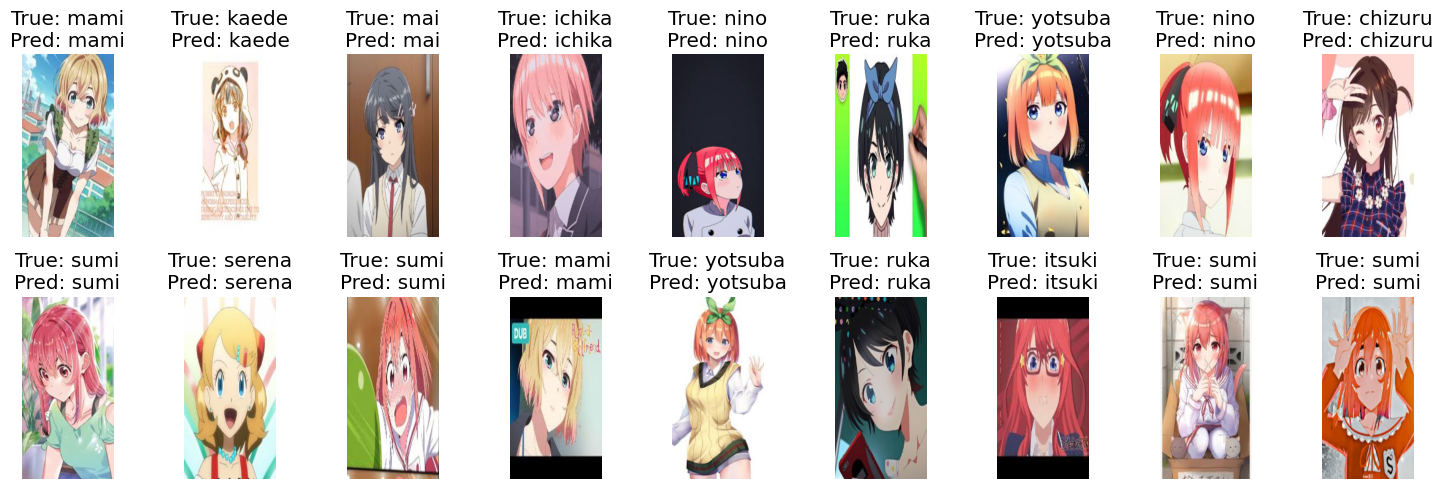

In [45]:
plot_images(X_test, y_test, predicted_classes, categories, num_images=18)

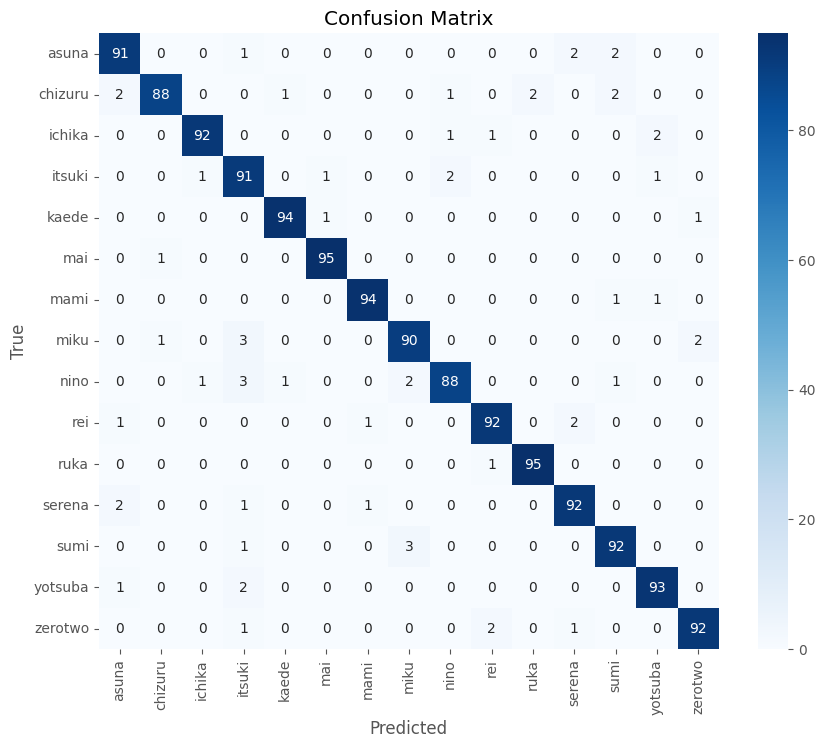

In [46]:
# confusion matrix
true_classes = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()